In [57]:
from __future__ import division
%matplotlib inline
import matplotlib.pyplot as plt
import copy
import numpy as np

import pickle
from scipy.integrate import simps
from scipy.interpolate import RectBivariateSpline
from classy import Class
import sys
sys.path.append("../scripts/") 
from postBornCrossSpectra import PostBorn_Bispec
import Cosmology as C
import kernels
import lab
plt.style.use('classic')

In [58]:
plotpath = '../output/plots/'

In [59]:
zmin = 1e-5
zmax = 1090.
kmin = 1e-4
kmax = 50

try:
    lab.cosmo_dict.pop('z_cmb')
except:
    pass

cosmo = [{'name':"EmasCosmo"},lab.cosmo_dict]

print(lab.cosmo_dict)

a     = np.linspace(1./(1.+zmin),1./(1.+zmax),500)  
z     = 1./a-1.

data  = C.CosmoData(cosmo[1],z)

sigma_zs = [0.1,0.4,0.4,0.4,0.4]
z0s      = [1.0,1.0,2.0,2.5,3.5]

{'A_s': 2.10732e-09, 'h': 0.677, 'k_pivot': 0.05, 'n_s': 0.96824, 'omega_b': 0.02247, 'omega_cdm': 0.11923, 'output': 'tCl,mPk', 'perturb_sampling_stepsize': 0.01, 'P_k_max_1/Mpc': 30.0, 'non linear': 'halofit'}
computing distances, derived parameters...
{'Neff': 3.046}
{'h': 0.677}
{'m_ncdm_tot': 0.0}
{'omega_m': 0.6745515980724002}


In [60]:
#compute correction following Krause&Hirata
#always use trapz rule for accurate results!
#redefinition with l'-> l'-l
def get_regularized_sum_of_terms(L,L1,phi,M,method='trapz'):
    nu = np.cos(phi)
    res=[]
    for LL in L:
        resL1=[]
        for LL1 in L1:
            L_= LL*np.sqrt(1.+(LL1/LL)**2+2.*LL1/LL*nu)
            integrand =LL*LL1**3*(LL1*nu+LL)*(LL1+LL*nu)**2*(M(L_,LL1,grid=False)/L_**2/LL1**4-M(LL,LL1,grid=False)/LL**2/LL1**4)
            if method =='simps':
                resL1+=[simps(integrand,phi)]
            elif method =='trapz':
                resL1+=[np.trapz(integrand,phi)]
            elif method =='sum':
                resL1+=[np.sum(integrand*np.diff(phi)[0])]
        res+=[simps(resL1,L1)]
    res=4.*np.asarray(res)/(2*np.pi)**2
    return res


#numerical angular integration
def get_second_sum_of_terms(L,L1,M,method='trapz'):
    nu = np.cos(phi)
    res=[]
    for LL in L:
        resL1=[]
        for LL1 in L1:
            integrand = LL1*(LL*LL1**2*(-LL1*nu+LL)*(-LL1+LL*nu)**2-LL**2*(LL*LL1*nu)**2)*(M(LL,LL1,grid=False)/LL**2/LL1**4)
            if method =='simps':
                resL1+=[simps(integrand,phi)]
            elif method =='trapz':
                resL1+=[np.trapz(integrand,phi)]
            elif method =='sum':
                resL1+=[np.sum(integrand*np.diff(phi)[0])]
        res+=[simps(resL1,L1)]
    res=4.*np.asarray(res)/(2*np.pi)**2
    return res

In [61]:
first_kernel  = kernels.CMB_lens(data.chi_cmb,data)
simple_kernel = kernels.CMB_lens(None,data)

Mstarspls = []
PBs =[]
Cls= []
for z0, sigma_z in zip(z0s,sigma_zs):
    second_kernel = lab.gal_clus(lab.Gauss_redshift(sigma_z=sigma_z, z0=z0), lab.simple_bias)
    PB  = PostBorn_Bispec(data, zmin, data.z_cmb, first_kernel, second_kernel, simple_kernel, k_min=kmin,k_max=100, lmax=30000, acc=2)
    PBs+=[PB]
    Mstarspls+=[PB.Mstarsp]
    Cls+=[PB.CL_born]
ls = PB.ls

Initializing CLASS with halofit...
{'A_s': 2.10732e-09, 'h': 0.677, 'k_pivot': 0.05, 'n_s': 0.96824, 'omega_b': 0.02247, 'omega_cdm': 0.11923, 'output': 'mPk', 'perturb_sampling_stepsize': 0.01, 'P_k_max_1/Mpc': 101, 'non linear': 'halofit', 'z_max_pk': 1088.6464513003662, 'k_min_tau0': 0.002, 'k_max_tau0_over_l_max': 5.0, 'k_step_sub': 0.015, 'k_step_super': 0.0001, 'k_step_super_reduction': 0.1, 'k_per_decade_for_pk': 20, 'tol_perturb_integration': 1e-06, 'halofit_k_per_decade': 3000.0}
sigma8  0.822427245205793
zmax 1088.6464513003662
Initializing CLASS with halofit...
{'A_s': 2.10732e-09, 'h': 0.677, 'k_pivot': 0.05, 'n_s': 0.96824, 'omega_b': 0.02247, 'omega_cdm': 0.11923, 'output': 'mPk', 'perturb_sampling_stepsize': 0.01, 'P_k_max_1/Mpc': 101, 'non linear': 'halofit', 'z_max_pk': 1088.6464513003662, 'k_min_tau0': 0.002, 'k_max_tau0_over_l_max': 5.0, 'k_step_sub': 0.015, 'k_step_super': 0.0001, 'k_step_super_reduction': 0.1, 'k_per_decade_for_pk': 20, 'tol_perturb_integration': 1

In [62]:
#31 term only
def get_31_term_only(L,L1,M):
    return -L**2/np.pi*simps(M(L,L1)/L1,L1)

In [63]:
L     = np.logspace(0,4,200)
L1    = np.logspace(0,np.log10(20000),400)
# sampling for integrations
phi   = np.linspace(0.,2.*np.pi,1000,endpoint=True)

In [107]:
corrs=[]
for ii in range(len(Mstarspls)):
    print(ii),
    corrs+=[get_regularized_sum_of_terms(L,L1,phi,Mstarspls[ii],method='trapz')+get_second_sum_of_terms(L,L1,Mstarspls[ii],method='trapz')]
corrs = np.asarray(corrs)
np.save('../output/LimberPostBornResults_Gaussian.npy', [L,corrs,z0s,sigma_zs])

In [71]:
Cl31s=np.zeros_like(corrs)
for ii in range(len(Mstarspls)):
    print(ii)
    Cl31s[ii] = get_31_term_only(L,L1,Mstarspls[ii])
np.save('../output/LimberPostBornCl31_Gaussian.npy',[L,Cl31s,z0s,sigma_zs])

0
1
2
3
4


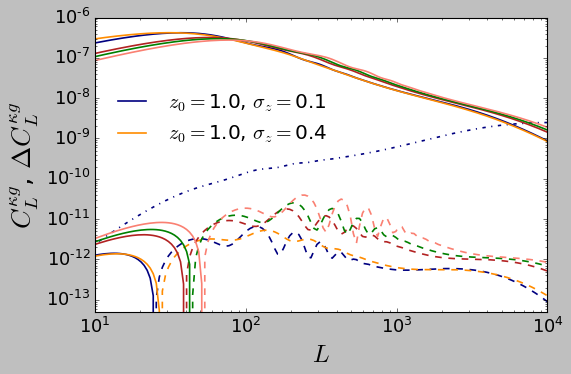

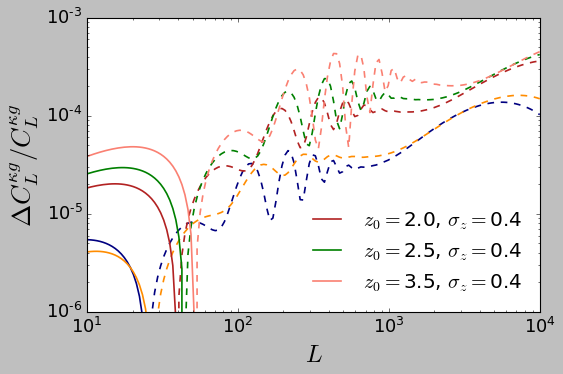

In [118]:
L, corrs,z0s_,sigma_zs_= np.load('../output/LimberPostBornResults_Gaussian.npy')
L1,Cl31s,z0s,sigma_zs  = np.load('../output/LimberPostBornCl31_Gaussian.npy')
assert(np.all(z0s_==z0s))
assert(np.all(sigma_zs==sigma_zs_))
L2,z0s_,sigma_zs_,clkgs= np.load('../output/Limber_flat_sky_clkg_Gaussian.npy')
assert(np.all(L1==L2))
assert(np.all(L1==L))
assert(np.all(z0s_==z0s))
assert(np.all(sigma_zs==sigma_zs_))

colors              = ['navy','darkorange','firebrick', 'green','salmon','lightseagreen']
plt.figure(figsize=(7.3,4.6))
for ii in range(len(z0s)):
    if ii <2:
        plt.loglog(L,clkgs[ii],lw=1.5,c=colors[ii],ls='-', label='$z_0=$%.1f, $\sigma_z=$%.1f'%(z0s[ii],sigma_zs[ii]))
    else:
        plt.loglog(L,clkgs[ii],lw=1.5,c=colors[ii],ls='-')
    plt.loglog(L,corrs[ii],lw=1.5,c=colors[ii],ls='-')
    plt.loglog(L,-corrs[ii],lw=1.5,c=colors[ii],ls='--')
    if ii==0:
        plt.loglog(L,-Cl31s[ii],lw=1.5,c=colors[ii],ls='-.')
plt.xlim(10,max(L))
plt.ylim(5e-14,1e-6)
plt.xlabel('$L$', fontsize=22)
plt.ylabel('$C_L^{\kappa g}$, $\Delta C_L^{\kappa g}$', fontsize=24)
plt.legend(loc=(0.02,0.54),frameon=False, fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig(plotpath+'Limber_results_Gaussian.pdf', bbox_inches='tight')
plt.show()

plt.figure(figsize=(7.3,4.6))
for ii in range(len(z0s)):
    if ii>1:
        plt.loglog(L,corrs[ii]/clkgs[ii],lw=1.5,c=colors[ii],ls='-', label='$z_0=$%.1f, $\sigma_z=$%.1f'%(z0s[ii],sigma_zs[ii]))
        plt.loglog(L,-corrs[ii]/clkgs[ii],lw=1.5,c=colors[ii],ls='--')
    else:
        plt.loglog(L,corrs[ii]/clkgs[ii],lw=1.5,c=colors[ii],ls='-')
        plt.loglog(L,-corrs[ii]/clkgs[ii],lw=1.5,c=colors[ii],ls='--')
plt.xlim(10,max(L))
plt.xlabel('$L$', fontsize=22)
plt.ylabel('$\Delta C_L^{\kappa g}/C_L^{\kappa g}$', fontsize=24)
plt.legend(loc='best',frameon=False, fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(1e-6,1e-3)
plt.savefig(plotpath+'Limber_results_Gaussian_ratio.pdf', bbox_inches='tight')
plt.show()

In [72]:
from classy import Class
cosmo = Class()

cosmo_dict=lab.cosmo_dict
cosmo_dict['output']   ='tCl,mPk'
cosmo_dict['perturb_sampling_stepsize']=0.01
cosmo_dict['P_k_max_1/Mpc']=30.
cosmo_dict['non linear']='halofit'
cosmo.empty()
cosmo.set(cosmo_dict)
cosmo.compute()

In [117]:
lensing_kernel = kernels.CMB_lens(data.chi_cmb,data)
chi_cmb = data.chi_cmb
chis = np.linspace(1.,chi_cmb,5000) #in Mpc/h
zs   = data.zchi(chis)
h = cosmo_dict['h']
print(h)
ells = L
result=[]
clkgs=[]
for z0, sigma_z in zip(z0s,sigma_zs):
    print(z0,sigma_z)
    kernel2 = lab.gal_clus(lab.Gauss_redshift(sigma_z=sigma_z, z0=z0), lab.simple_bias)
# cross in Limber, uncomment if you need different kernels than are saved
    result=[]
    for l_ in ells:
        integrand=[]
        for chi, z in zip(chis,zs):
            k = l_/chi #in h/Mpc
            try:
                Pk= cosmo.pk(k*h,0.)*h**3*lab.D_chi(chi)          
            except Exception as e: 
                #print(e)
                Pk= 0.
            integrand+=[lensing_kernel(chi,z)*kernel2(chi)*Pk/chi**2]

        result+=[np.trapz(integrand, chis)]
    clkgs+=[np.asarray(result)]


np.save('../output/Limber_flat_sky_clkg_Gaussian.npy',[ells,z0s,sigma_zs,clkgs])